In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/FinalProject/data.zip -d /content

Archive:  /content/drive/MyDrive/FinalProject/data.zip
   creating: /content/data/
   creating: /content/data/images/
  inflating: /content/data/images/1UP47_2103_2418.png  
  inflating: /content/data/images/1UP47_2103_2418_1.png  
  inflating: /content/data/images/1UP47_2103_2419.png  
  inflating: /content/data/images/1UP47_2103_2419_1.png  
  inflating: /content/data/images/1UP47_2103_2419_3.png  
  inflating: /content/data/images/1UP47_2103_2420.png  
  inflating: /content/data/images/1UP47_2103_2420_1.png  
  inflating: /content/data/images/1UP47_2103_2420_3.png  
  inflating: /content/data/images/1UP47_2103_2420_5.png  
  inflating: /content/data/images/1UP47_2103_2421.png  
  inflating: /content/data/images/1UP47_2103_2421_1.png  
  inflating: /content/data/images/1UP47_2103_2421_5.png  
  inflating: /content/data/images/1UP47_2103_2423_3.png  
  inflating: /content/data/images/1UP47_2103_2423_5.png  
  inflating: /content/data/images/1V857S_2103_6509.png  
  inflating: /content

In [2]:
!unzip /content/drive/MyDrive/FinalProject/testdata.zip -d /content

Archive:  /content/drive/MyDrive/FinalProject/testdata.zip
   creating: /content/testdata/
   creating: /content/testdata/t1/
  inflating: /content/testdata/t1/neg1.png  
  inflating: /content/testdata/t1/pos.png  
  inflating: /content/testdata/t1/query.png  
   creating: /content/testdata/t2/
  inflating: /content/testdata/t2/neg1.png  
  inflating: /content/testdata/t2/neg2.png  
  inflating: /content/testdata/t2/neg3.png  
  inflating: /content/testdata/t2/neg4.png  
  inflating: /content/testdata/t2/pos.png  
  inflating: /content/testdata/t2/query.png  
   creating: /content/testdata/t3/
  inflating: /content/testdata/t3/neg1.png  
  inflating: /content/testdata/t3/neg2.png  
  inflating: /content/testdata/t3/neg3.png  
  inflating: /content/testdata/t3/pos.png  
  inflating: /content/testdata/t3/query.png  


# Training Section

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## Configurations and Data

In [ ]:
DATA_DIR = '/content/data/images/'
TRAIN_CSV_FILE = '/content/data/train.csv'
VALID_CSV_FILE = '/content/data/valid.csv'

BATCH_SIZE = 12

DEVICE = 'cuda'
MODEL_PATH = '/content/drive/MyDrive/best_model.pt'

In [ ]:
train_df = pd.read_csv(TRAIN_CSV_FILE)
train_df.head()

,Anchor,Positive,Negative
0,1V857S_2103_6509.png,1V857S_2103_6509_1.png,1V857S_2103_6510_4.png
1,2GW65S_2202_6980.png,2GW65S_2202_6980_1.png,2GW65S_2202_6981_1.png
2,2H824_2202_13409.png,2H824_2202_13409_2.png,2H824_2202_13410_1.png
3,2H824_2202_13409.png,2H824_2202_13409_2.png,2H824_2202_13411_4.png
4,2H824_2202_13409.png,2H824_2202_13409_2.png,2H824_2202_13412_2.png


In [ ]:
valid_df = pd.read_csv(VALID_CSV_FILE)
valid_df.head()

,Anchor,Positive,Negative
0,1UP47_2103_2418.png,1UP47_2103_2418_1.png,1UP47_2103_2419_1.png
1,1UP47_2103_2418.png,1UP47_2103_2418_1.png,1UP47_2103_2420_1.png
2,1UP47_2103_2418.png,1UP47_2103_2418_1.png,1UP47_2103_2421_5.png
3,1UP47_2103_2418.png,1UP47_2103_2418_1.png,1UP47_2103_2423_3.png
4,1UP47_2103_2419.png,1UP47_2103_2419_1.png,1UP47_2103_2420_1.png


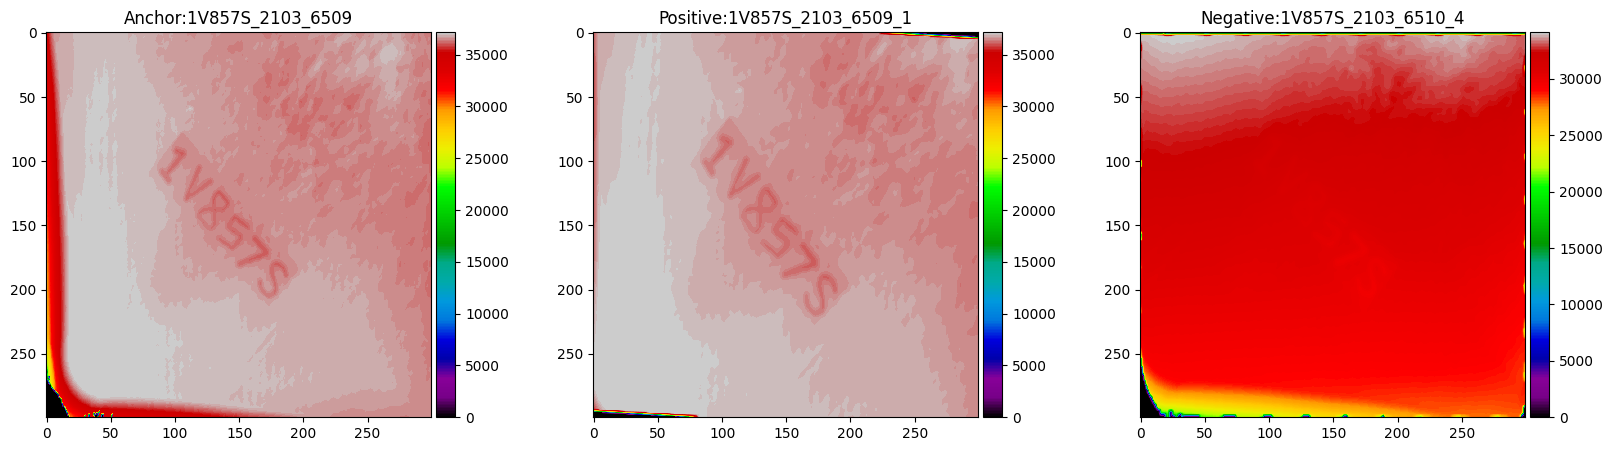

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

row = train_df.iloc[0]

A_img = cv2.imread(DATA_DIR + row.Anchor, -1)
P_img = cv2.imread(DATA_DIR + row.Positive, -1)
N_img = cv2.imread(DATA_DIR + row.Negative, -1)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))
ax1.set_title(f"Anchor:{row.Anchor.split('.')[0]}")
im1 = ax1.imshow(A_img, cmap = 'nipy_spectral')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical')

ax2.set_title(f"Positive:{row.Positive.split('.')[0]}")
im2 = ax2.imshow(P_img, cmap = 'nipy_spectral')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='vertical')

ax3.set_title(f"Negative:{row.Negative.split('.')[0]}")
im3 = ax3.imshow(N_img, cmap = 'nipy_spectral')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='vertical')

## Dataset and Dataloader

In [ ]:
class dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = torch.from_numpy(cv2.imread(DATA_DIR + row.Anchor, -1).astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
    P_img = torch.from_numpy(cv2.imread(DATA_DIR + row.Positive, -1).astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
    N_img = torch.from_numpy(cv2.imread(DATA_DIR + row.Negative, -1).astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
    return A_img, P_img, N_img

In [ ]:
trainset = dataset(train_df)
validset = dataset(valid_df)
print(f'Number of trainset : {len(trainset)}')
print(f'Number of validset : {len(validset)}')

Number of trainset : 3367
Number of validset : 979


In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Number of batches in trainloader : {len(trainloader)}")
print(f"Number of batches in validloader : {len(validloader)}")

Number of batches in trainloader : 281
Number of batches in validloader : 82


In [ ]:
for A, P, N in trainloader:
  break
    
print(f"Image batch shape : {A.shape}")

Image batch shape : torch.Size([12, 1, 300, 300])


## Model 

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.prelayer = nn.Conv2d(1, 3, kernel_size=1, bias=False)
    self.net = torchvision.models.resnet50()
  def forward(self, images):
    images = self.net(self.prelayer(images))
    return images

In [ ]:
model = Model()
model.to(DEVICE)

Model(
  (prelayer): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

## Train and Evaluation Function

In [ ]:
def batch_dist(a_emb, b_emb):
  dist = a_emb - b_emb
  dist = np.dot(dist, dist.T)
  dist[dist < 0] = 0
  dist = np.diag(np.sqrt(dist))
  return dist

In [ ]:
def train(model, loader, optimizer, criterion):
  total_loss = 0.0
  total_eval = 0
  total_corr = 0
  for A, P, N in tqdm(loader):
    A = A.to(DEVICE); P = P.to(DEVICE); N = N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    ap_dist = batch_dist(A_embs.cpu().detach().numpy(), P_embs.cpu().detach().numpy())
    an_dist = batch_dist(A_embs.cpu().detach().numpy(), N_embs.cpu().detach().numpy())
    total_eval += len(ap_dist)
    corr = np.count_nonzero(ap_dist < an_dist)
    total_corr += corr

    loss = criterion(A_embs, P_embs, N_embs)
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
  return total_loss/len(loader), round(total_corr/total_eval, 7)*100

In [ ]:
def eval(model, loader, criterion):
  total_loss = 0.0
  total_eval = 0
  total_corr = 0
  with torch.no_grad():
    for A, P, N in tqdm(loader):
      A = A.to(DEVICE); P = P.to(DEVICE); N = N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      ap_dist = batch_dist(A_embs.cpu().detach().numpy(), P_embs.cpu().detach().numpy())
      an_dist = batch_dist(A_embs.cpu().detach().numpy(), N_embs.cpu().detach().numpy())
      total_eval += len(ap_dist)
      corr = np.count_nonzero(ap_dist < an_dist)
      total_corr += corr

      loss = criterion(A_embs, P_embs, N_embs)
      total_loss += loss.item()
    return total_loss/len(loader), round(total_corr/total_eval, 7)*100

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training

In [ ]:
best_valid_acc = 0
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

EPOCHS = 5

for idx in range(EPOCHS):
  print(f'EPOCH : {idx+1}')
  loss, acc = train(model, trainloader, optimizer, criterion)
  train_loss.append(loss)
  train_acc.append(acc)

  loss, acc = eval(model, validloader, criterion)
  valid_loss.append(loss)
  valid_acc.append(acc)

  if valid_acc[-1] > best_valid_acc:
    torch.save(model.state_dict(), MODEL_PATH)
    best_valid_acc = valid_acc[-1]
    print('[WEIGHTS SAVED]')
  print(f'train_loss : {train_loss[-1]} valid_loss : {valid_loss[-1]}')
  print(f'train_acc : {train_acc[-1]}% valid_acc : {valid_acc[-1]}%\n')

EPOCH : 1


100%|██████████| 82/82 [00:24<00:00,  3.38it/s]


[WEIGHTS SAVED]
train_loss : 1.259320017166628 valid_loss : 0.6686919995004357
train_acc : 79.38817999999999% valid_acc : 68.70877%

EPOCH : 2


100%|██████████| 82/82 [00:24<00:00,  3.35it/s]


[WEIGHTS SAVED]
train_loss : 0.3226689697770249 valid_loss : 0.45110274302182585
train_acc : 88.32789% valid_acc : 74.64656%

EPOCH : 3


100%|██████████| 82/82 [00:24<00:00,  3.39it/s]


train_loss : 0.18610094493798568 valid_loss : 0.6389069230247448
train_acc : 92.78289% valid_acc : 66.541%

EPOCH : 4


100%|██████████| 82/82 [00:24<00:00,  3.37it/s]


[WEIGHTS SAVED]
train_loss : 0.15472561681120126 valid_loss : 0.4257524603404241
train_acc : 94.17879% valid_acc : 76.24882%

EPOCH : 5


100%|██████████| 82/82 [00:24<00:00,  3.35it/s]

train_loss : 0.18946017729933787 valid_loss : 0.44735331654671273
train_acc : 92.90169% valid_acc : 75.21206000000001%



# Test Section

## Import Packages

In [3]:
import numpy as np
import cv2
import os
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn

## Configuration

In [4]:
DATA_DIR = '/content/testdata/'

DEVICE = 'cuda'
MODEL_PATH = '/content/drive/MyDrive/best_model.pt'

## Model
You can just copy the whole `class Model` in Training Section.

In [5]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.prelayer = nn.Conv2d(1, 3, kernel_size=1, bias=False)
    self.net = torchvision.models.resnet50()
  def forward(self, images):
    images = self.net(self.prelayer(images))
    return images

In [6]:
model = Model()
model.to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

## Test

In [7]:
def dist(a_emb, b_emb):
  dist = a_emb - b_emb
  dist = np.dot(dist, dist.T)
  dist[dist < 0] = 0
  dist = np.sqrt(dist)[0][0]
  return dist

In [8]:
def test(model, folder, candidates):
  query_img = torch.from_numpy(cv2.imread(DATA_DIR + folder + 'query.png', -1).astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
  query_img = query_img.unsqueeze(0).to(DEVICE)
  query_emb = model(query_img)
  dists = {}
  for cand in candidates:
    cand_img = torch.from_numpy(cv2.imread(DATA_DIR + folder + cand, -1).astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
    cand_img = cand_img.unsqueeze(0).to(DEVICE)
    cand_emb = model(cand_img)
    dists[cand] = dist(query_emb.cpu().detach().numpy(), cand_emb.cpu().detach().numpy())
  return len(candidates)-1, np.count_nonzero(list(dists.values()) > dists['pos.png'])

In [9]:
testcases = os.listdir(DATA_DIR)
total_eval = 0
total_corr = 0

for testcase in testcases:
  testcase += '/'
  files = os.listdir(DATA_DIR + testcase)
  files.remove('query.png')
  eval, corr = test(model, testcase, files)
  total_eval += eval
  total_corr += corr
tz = timezone(timedelta(hours=+8))
print(f'Current time: {datetime.now(tz)}')
print(f'Number of test cases: {len(testcases)}')
print(f'Test accuracy: {round(total_corr/total_eval, 7)*100}%')

Current time: 2023-05-07 19:34:23.268043+08:00
Number of test cases: 3
Test accuracy: 62.5%
